In [3]:
import requests
import json
from collections import Counter
import pprint
pp = pprint.PrettyPrinter(indent=5)

This notebook provides an overview of the ROBOKOP Question Builder found at `https://robokop.renci.org/question-builder`.  It assumes you are familiar with the concepts and examples covered in `HelloRobokop.ipynb`.

The Question Builder tool allows users to add and remove nodes and predicates such as in the image below.  Terms used in the node and predicate fields are retrieved from the ROBOKOP Knowledge Base as options.  If a term isn't found in the Knowledge Base, then it may not be used as a query term.  Here, Buprenorphine is selected from the list of options to submit to the query searching for something (node n1) related to `Buprenorphine` and `Tremor`

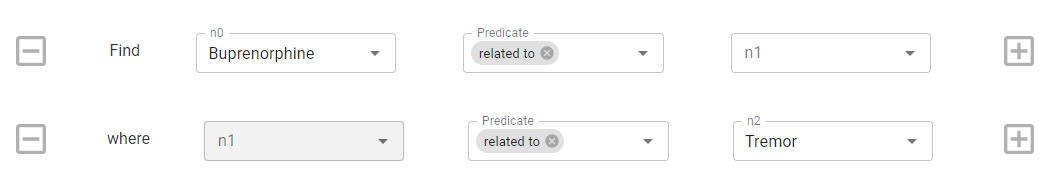

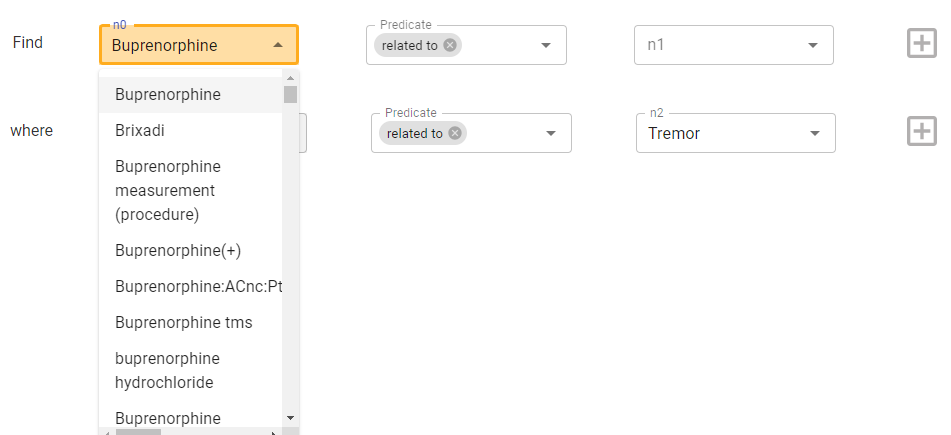

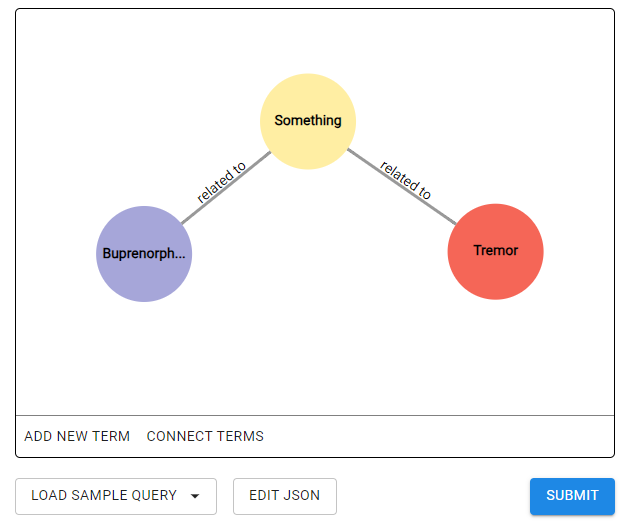

After submitting the query, a Knowledge Graph Bubble containing related terms and list of pathways with those related terms are returned.  Since the Question Builder send the query to Aragorn, pathways are sorted and ranked based on their scores.  Each pathway can be expanded to show a list of the edges between each of the nodes.

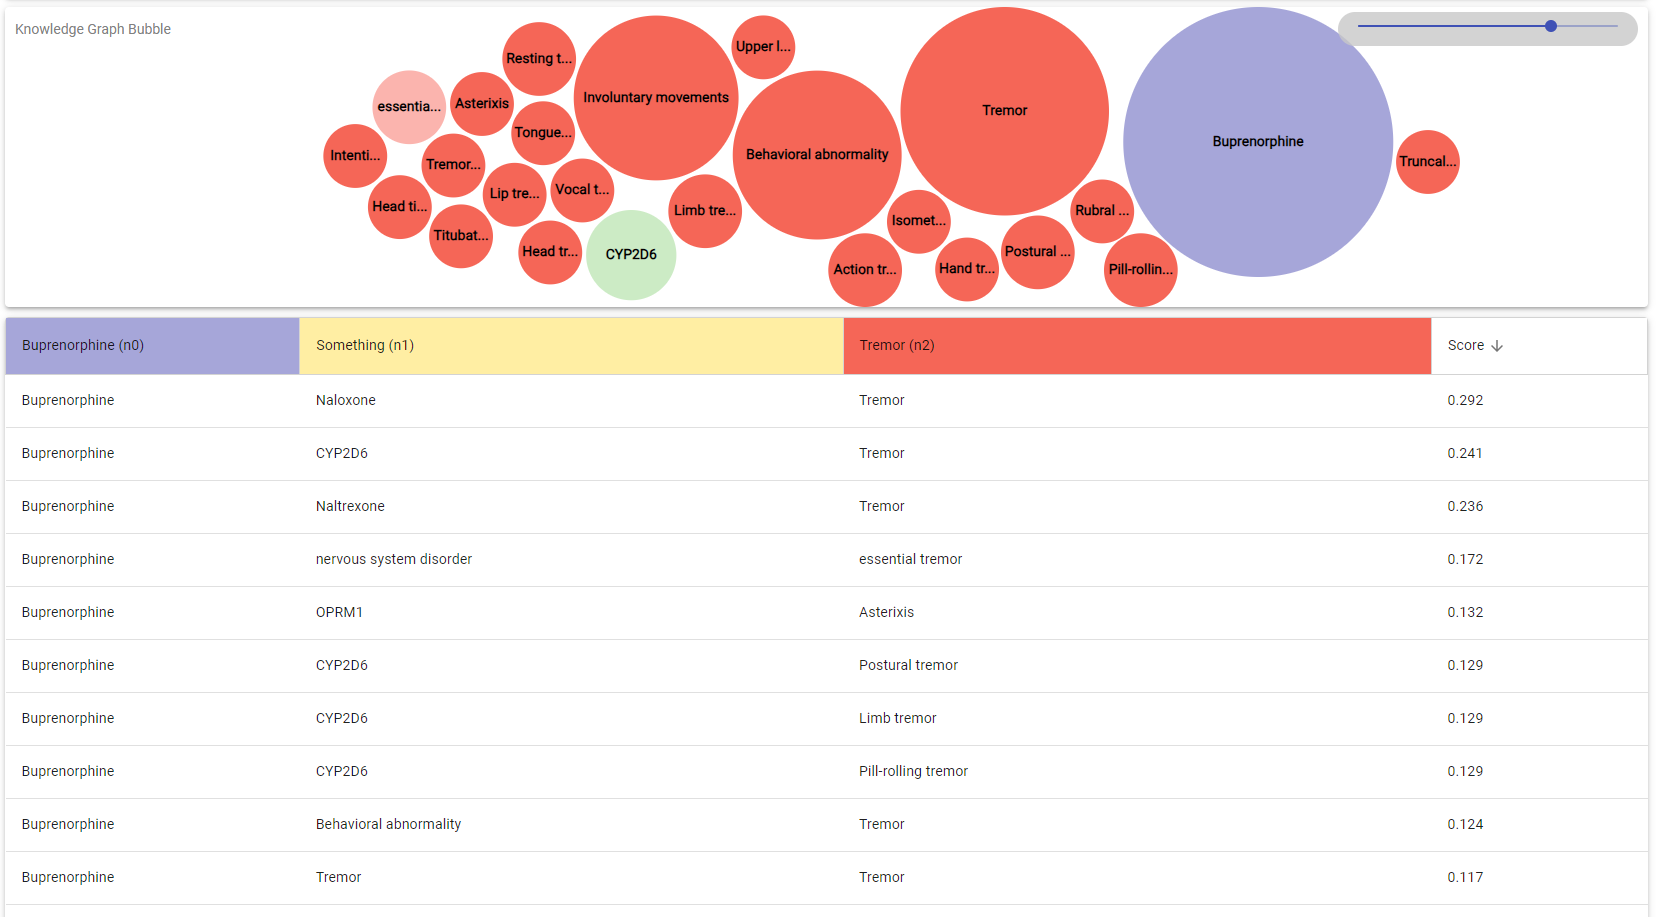

The expansion of the Pathway `Buprenorphine -> CYP2D6 -> Tremor` used in `HelloRobokop.ipynb` is shown below.  The Answer Explorer shows all of the edges found in the database including an additional edge indicating that terms appear together in literature, here being `Buprenorphine - CYP2D6`, `Buprenorphine - Tremor`, and `CYP2D6 - Tremor`.  Nine total edges are found in the Answer Explorer here.

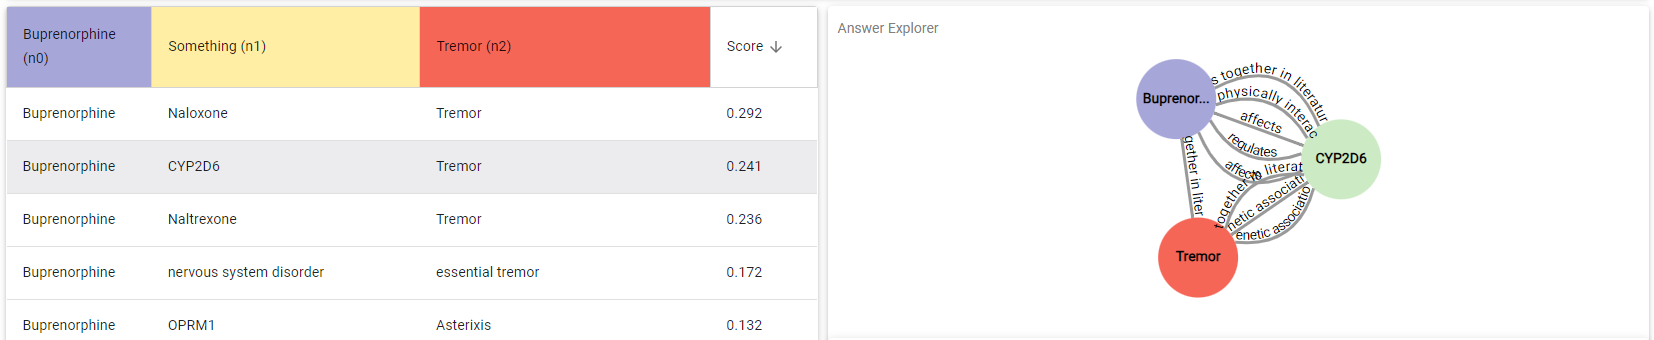

These same nine results are found by querying against Aragorn using TRAPI below.

In [4]:
query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": ["PUBCHEM.COMPOUND:644073"],
            "categories": ["biolink:ChemicalEntity"]
          },
          "n01": {
              "categories": ["biolink:BiologicalProcessOrActivity","biolink:Gene","biolink:Pathway"]
          },
          "n02": {
            "ids": ["HP:0001337"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }


In [8]:
aragorn_submit = "https://aragorn-u24.apps.renci.org/robokop/query"
response = requests.post(aragorn_submit,json=query)
print(response.status_code)
number_pathway_results = len(response.json()['message']['results'])
kg = response.json()['message']['knowledge_graph']
results = response.json()['message']['results']
print(len(response.json()['message']['results']))

200
7


In [13]:
import pandas as pd
import os

cols = []
for node in sorted(results[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_df = pd.DataFrame(columns = cols)

results_list = []
for result in results:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg['nodes'][node_id]['name']

    results_list.append(pd.DataFrame([result_dict]))
results_df = pd.concat(results_list)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_df[cols].to_numpy()]

In [14]:
for i in range(number_pathway_results):
    if "Buprenorphine_CYP2D6_Tremor" in combined_node_list[i]:
        print(f"Pathway result: {combined_node_list[i]}")
        edge_bindings = results[i]['edge_bindings']

        edge_ids = []
        for edge_name, edge_list in edge_bindings.items():
            edge_ids.append({edge_name: [x['id'] for x in edge_list]})

        string_out_list = []
        for edge_dict in edge_ids:
            for edge_name, edge_list in edge_dict.items():
                for edge_id in edge_list:
                    subject_id = kg['edges'][edge_id]['subject']
                    subject = kg['nodes'][subject_id]['name']
                    predicate = kg['edges'][edge_id]['predicate']
                    object_id = kg['edges'][edge_id]['object']
                    object = kg['nodes'][object_id]['name']
                    string_out = f"{subject} -> {predicate} -> {object}"
                    string_out_list.append(string_out)
        string_out_dict = dict(Counter(string_out_list).items())
        pp.pprint(string_out_dict)
        print("")


Pathway result: Buprenorphine_CYP2D6_Tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2,
     'CYP2D6 -> biolink:occurs_together_in_literature_with -> Buprenorphine': 1,
     'Tremor -> biolink:occurs_together_in_literature_with -> Buprenorphine': 1,
     'Tremor -> biolink:occurs_together_in_literature_with -> CYP2D6': 1}

